# Description

This competition is the final problem statement of Recognizance'24, the ML event of Prastuti, the Electrical Dept. fest of IIT BHU.

My task is to develop a machine learning model capable of identifying fraudulent transactions within credit card data.

The aim is to create a predictive algorithm that distinguishes between legitimate and fraudulent purchases, thereby safeguarding customers from unauthorized charges.

My model's performance could potentially help credit card companies prevent fraud, protect their customers, and ensure the integrity of their transaction processing systems.

In [ ]:
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, roc_auc_score,
    average_precision_score, confusion_matrix,
    classification_report, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC


In [ ]:
from datetime import datetime
def print_current_datetime():
    now = datetime.now()
    print("Дата та час розрахунків: ", now.strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:

def plot_training_history(history):
    # Extract the keys for the AUC and loss metrics
    auc_keys = [key for key in history.history.keys() if 'auc' in key and 'val' not in key]
    val_auc_keys = [key for key in history.history.keys() if 'val_auc' in key]
    loss_key = 'loss'
    val_loss_key = 'val_loss'

    # Check if we found the expected keys, otherwise we take the last ones
    auc_key = auc_keys[-1] if auc_keys else 'auc'
    val_auc_key = val_auc_keys[-1] if val_auc_keys else 'val_auc'

    # Set up a figure with two subplots aligned horizontally
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot AUC on the first subplot
    ax1.plot(history.history[auc_key], label='Train AUC')
    ax1.plot(history.history[val_auc_key], label='Validation AUC')
    ax1.set_title('Model AUC')
    ax1.set_ylabel('AUC')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper left')

    # Plot loss on the second subplot
    ax2.plot(history.history[loss_key], label='Train Loss')
    ax2.plot(history.history[val_loss_key], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper left')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_lgbm(results):
    # Plotting the training loss and AUC
    plt.figure(figsize=(12, 5))

    # Assume that the first key is for training and the second is for validation
    keys = list(results.keys())
    training_key = keys[0]
    valid_key = keys[1] if len(keys) > 1 else training_key

    # Plotting the training and test AUC scores
    plt.subplot(1, 2, 1)
    plt.plot(results[training_key]['auc'], label=f'{training_key} AUC')
    plt.plot(results[valid_key]['auc'], label=f'{valid_key} AUC')
    plt.title('Training and Test AUC')
    plt.xlabel('Iterations')
    plt.ylabel('AUC')
    plt.legend()

    # Plotting the training and test loss (log loss)
    plt.subplot(1, 2, 2)
    plt.plot(results[training_key]['binary_logloss'], label=f'{training_key} Loss')
    plt.plot(results[valid_key]['binary_logloss'], label=f'{valid_key} Loss')
    plt.title('Training and Test Loss (Log Loss)')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print the current datetime
    print_current_datetime()

# Load and preprocess data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_file_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/train.csv'
df_train = pd.read_csv(train_file_path)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
reduce_mem_usage(df_train)

Mem. usage decreased to  9.58 Mb (73.8% reduction)


,id,Time,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount,IsFraud
0,0,0.0,2.074219,-0.129395,-1.137695,0.412842,-0.192627,-1.209961,0.110718,-0.263428,...,-0.334717,-0.887695,0.336670,-0.110840,-0.291504,0.207764,-0.076599,-0.059570,1.980469,0
1,1,0.0,1.999023,-1.250977,-0.520996,-0.894531,-1.122070,-0.270752,-1.029297,0.050201,...,0.054840,-0.038361,0.133545,-0.461914,-0.465576,-0.464600,-0.009415,-0.038239,84.000000,0
2,2,0.0,0.091553,1.004883,-0.223389,-0.435303,0.667480,-0.988281,0.948242,-0.084778,...,-0.326660,-0.803711,0.154541,0.951172,-0.506836,0.085022,0.224487,0.087341,2.689453,0
3,3,0.0,1.979492,-0.184937,-1.064453,0.120117,-0.215210,-0.648926,-0.087830,-0.035370,...,-0.095520,-0.079773,0.167725,-0.042938,0.000799,-0.096130,-0.057770,-0.073853,1.000000,0
4,4,0.0,1.026367,-0.171875,1.204102,1.244141,-0.636719,1.098633,-0.938477,0.569336,...,0.099182,0.608887,0.027908,-0.262695,0.257812,-0.252930,0.108337,0.021057,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149995,73899.0,1.277344,0.665527,-0.687988,1.135742,0.494873,-0.555176,0.252441,-0.132690,...,-0.114746,-0.221558,-0.233032,-0.745117,0.799316,-0.244873,0.037872,0.042664,1.000000,0
149996,149996,73899.0,0.807617,-1.813477,0.421143,-0.576660,-1.601562,-0.665527,-0.230347,-0.297119,...,0.270996,0.014435,-0.193726,0.387695,0.169312,-0.444580,-0.043793,0.072510,349.750000,0
149997,149997,73899.0,0.836426,-0.351562,0.650391,1.066406,-0.234863,0.844238,-0.409668,0.382568,...,0.285889,0.721191,-0.067871,-0.273682,0.232910,-0.286621,0.054077,0.031403,116.125000,0
149998,149998,73899.0,-0.807129,0.383789,2.296875,1.428711,-2.343750,1.073242,-0.203613,0.456543,...,0.228760,1.296875,-0.038757,0.827637,-0.743164,0.914551,0.307617,-0.010201,179.000000,0


# EDA - explorary data analys

## Exploring data

Let's check the proportion of fraud class '1'

In [ ]:
# df_train['Class'].value_counts()
length = len(df_train)
count_fraud = (df_train['IsFraud'] == 1).sum()
pers_fraud = count_fraud/length
print(f'Fraud cases represents {100*pers_fraud:.2f}% ({count_fraud} instances) of  all data {length}')

Fraud cases represents 0.18% (269 instances) of  all data 150000


**such big discruption in data represent a serious challage to the quality of models forecasting**

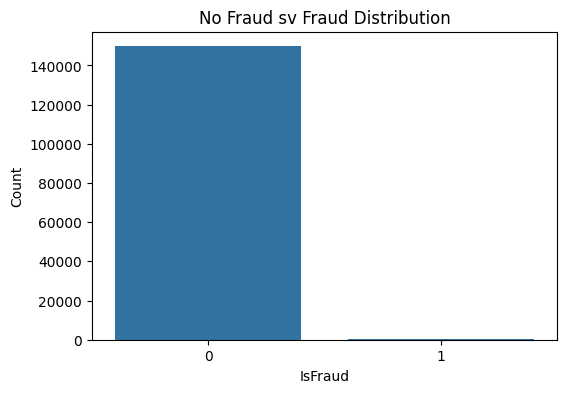

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='IsFraud', data=df_train)
plt.title('No Fraud sv Fraud Distribution')
plt.xlabel('IsFraud')
plt.ylabel('Count')
plt.show()

In [ ]:
# Create a boolean mask where 'IsFraud' is 1
fraud_mask = df_train['IsFraud'] == 1

# Use the mask to filter the dataframe and select the desired columns
fraudulent_transactions = df_train[fraud_mask][['Time', 'Transaction_Amount', 'IsFraud']]

# Now we can work with this new dataframe
print(fraudulent_transactions)


           Time  Transaction_Amount  IsFraud
1681      764.0          136.625000        1
2039      923.0            2.000000        1
2090     1028.0            0.119995        1
3072     1328.0           23.312500        1
3780     1438.0            4.988281        1
...         ...                 ...      ...
147761  73456.0            1.000000        1
147901  73499.0            0.759766        1
147942  73514.0          202.500000        1
148715  73626.0            0.750000        1
149812  73885.0           12.312500        1

[269 rows x 3 columns]


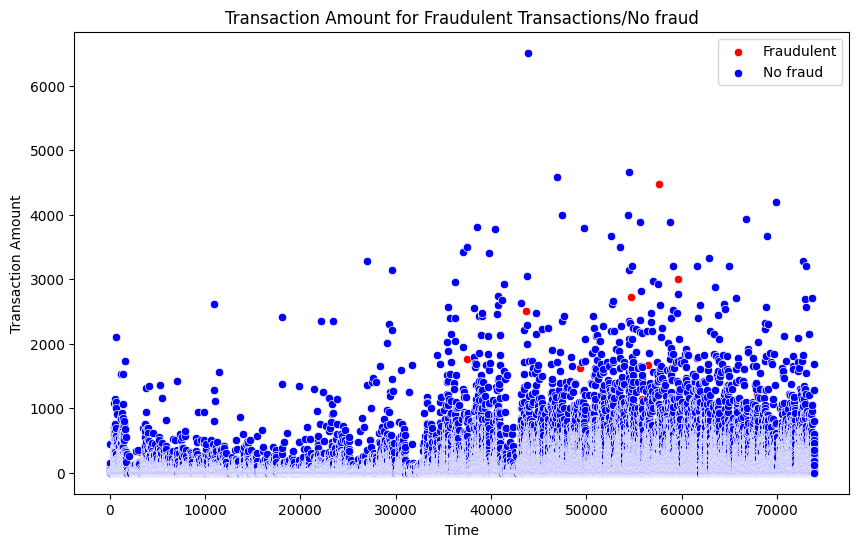

In [ ]:
# fraudulent_transactions and no_fraudulent_transactions
fraudulent_transactions = df_train[df_train['IsFraud'] == 1]
no_fraudulent_transactions = df_train[df_train['IsFraud'] == 0]

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for Transaction Amount vs Time for fraudulent transactions
sns.scatterplot(data=fraudulent_transactions, x='Time', y='Transaction_Amount', color='red', label='Fraudulent')
sns.scatterplot(data=no_fraudulent_transactions, x='Time', y='Transaction_Amount', color='blue', label='No fraud')

plt.title('Transaction Amount for Fraudulent Transactions/No fraud')
plt.xlabel('Time')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

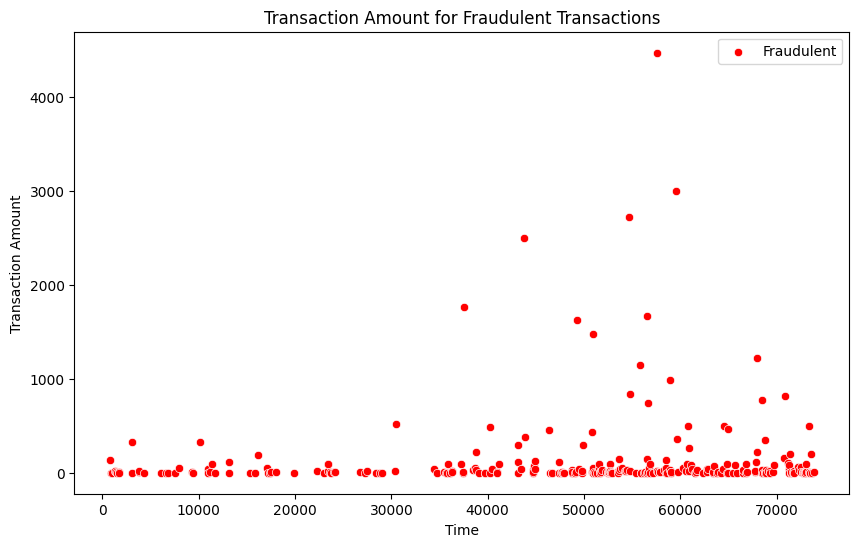

In [ ]:
# looking only for fraudulent transactions

plt.figure(figsize=(10, 6))
sns.scatterplot(data=fraudulent_transactions, x='Time', y='Transaction_Amount', color='red', label='Fraudulent')
plt.title('Transaction Amount for Fraudulent Transactions')
plt.xlabel('Time')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

## Data transformation
scale the features above, in order to balance data range of all set

In [ ]:
from sklearn.preprocessing import StandardScaler

def preproccess_data(df):
  df = df.drop(['id'], axis=1)
  scaler = StandardScaler()
  df[['Time', 'Transaction_Amount']] = scaler.fit_transform(df[['Time', 'Transaction_Amount']])
  return df


In [ ]:
df_train_pp = preproccess_data(df_train)

In [ ]:
df_train_pp.head()

,Time,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount,IsFraud
0,-2.657548,2.074219,-0.129395,-1.137695,0.412842,-0.192627,-1.209961,0.110718,-0.263428,0.742188,...,-0.334717,-0.887695,0.336670,-0.110840,-0.291504,0.207764,-0.076599,-0.059570,-0.435283,0
1,-2.657548,1.999023,-1.250977,-0.520996,-0.894531,-1.122070,-0.270752,-1.029297,0.050201,-0.109924,...,0.054840,-0.038361,0.133545,-0.461914,-0.465576,-0.464600,-0.009415,-0.038239,0.081496,0
2,-2.657548,0.091553,1.004883,-0.223389,-0.435303,0.667480,-0.988281,0.948242,-0.084778,-0.042023,...,-0.326660,-0.803711,0.154541,0.951172,-0.506836,0.085022,0.224487,0.087341,-0.430816,0
3,-2.657548,1.979492,-0.184937,-1.064453,0.120117,-0.215210,-0.648926,-0.087830,-0.035370,0.885742,...,-0.095520,-0.079773,0.167725,-0.042938,0.000799,-0.096130,-0.057770,-0.073853,-0.441461,0
4,-2.657548,1.026367,-0.171875,1.204102,1.244141,-0.636719,1.098633,-0.938477,0.569336,0.692871,...,0.099182,0.608887,0.027908,-0.262695,0.257812,-0.252930,0.108337,0.021057,-0.441461,0


# Autoencoder with Keras, NN model

Unsupervised learning technique, that can learn to identify patterns or anomalies in data. In fraud detection, we deal with highly imbalanced datasets where fraudulent transactions are rare compared to normal transactions.

Training autoencoder, it will learn the "normal" pattern of the input data.
After that, we will run the autoencoder on normal transactions and it should ideally reconstruct any normal transaction with low error.
Fraudulent transactions, which are not seen during training and which differ in pattern from normal transactions, will likely have a higher reconstruction error.

## split data

In [ ]:
# Splitting the data into Features & Targets
X = df_train_pp.drop(columns='IsFraud', axis=1)
y = df_train_pp['IsFraud']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(90000, 30) (60000, 30) (90000,) (60000,)


## Autoencoder model - define, run, fit

In [ ]:
encoding_dim = 128

# Define the autoencoder
model = Sequential([
    Dense(encoding_dim, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(encoding_dim, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(X_train.shape[1], activation='sigmoid')])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# EarlyStopping callback to halt training upon sufficient convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the autoencoder
history = model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)

# Print current date and time
print_current_datetime()

Epoch 1/10
1407/1407 [==============================] - 6s 3ms/step - loss: 0.6074 - val_loss: 0.5319
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5521 - val_loss: 0.5154
Epoch 3/10
1407/1407 [==============================] - 4s 3ms/step - loss: 0.5405 - val_loss: 0.5071
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5331 - val_loss: 0.5020
Epoch 5/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5279 - val_loss: 0.4974
Epoch 6/10
1407/1407 [==============================] - 5s 3ms/step - loss: 0.5241 - val_loss: 0.4944
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.5212 - val_loss: 0.4920
Epoch 8/10
1407/1407 [==============================] - 5s 3ms/step - loss: 0.5189 - val_loss: 0.4905
Epoch 9/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5171 - val_loss: 0.4880
Epoch 10/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.515

### Encoder part to apply on train and test data

In [ ]:
# Extract the encoder part from the autoencoder model
encoder = Model(inputs=model.input, outputs=model.layers[-3].output)

# Encode the training and test data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

1875/1875 [==============================] - 3s 1ms/step


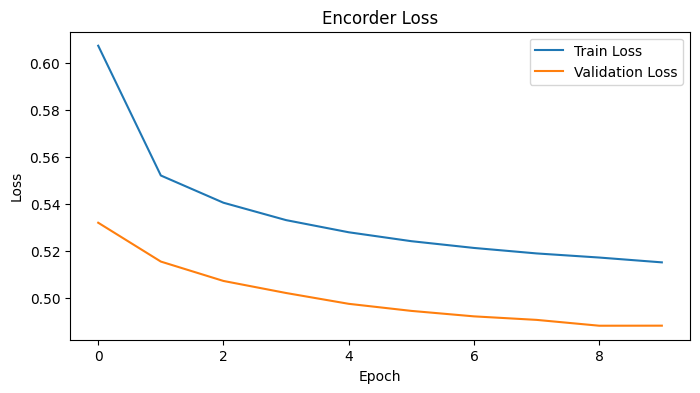

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Encorder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


**Both losses does not appear to converge, with a certain gap between the training and validation loss. This indicates that the model is not generalizing very well to unseen data. I suppose that the reason is very embalanced data**

## **Classifier for encorderded data**

**Let's find appropriate model**

In [ ]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert the class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

### Start with RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the encoded training data
classifier.fit(X_train_encoded, y_train)

# Predict probabilities on the encoded training and test set
y_train_pred_proba = classifier.predict_proba(X_train_encoded)[:, 1]  # Probabilities for the positive class on training data
y_test_pred_proba = classifier.predict_proba(X_test_encoded)[:, 1]  # Probabilities for the positive class on test data

# Calculate the AUC scores for train and test
train_auc_score = roc_auc_score(y_train, y_train_pred_proba)
test_auc_score = roc_auc_score(y_test, y_test_pred_proba)

# Print AUC scores
print("Train AUC Score:", train_auc_score)
print("Test AUC Score:", test_auc_score)

# Print the current datetime
print_current_datetime()

Train AUC Score: 1.0
Test AUC Score: 0.6928930408067855
Дата та час розрахунків:  2024-04-18 15:27:00


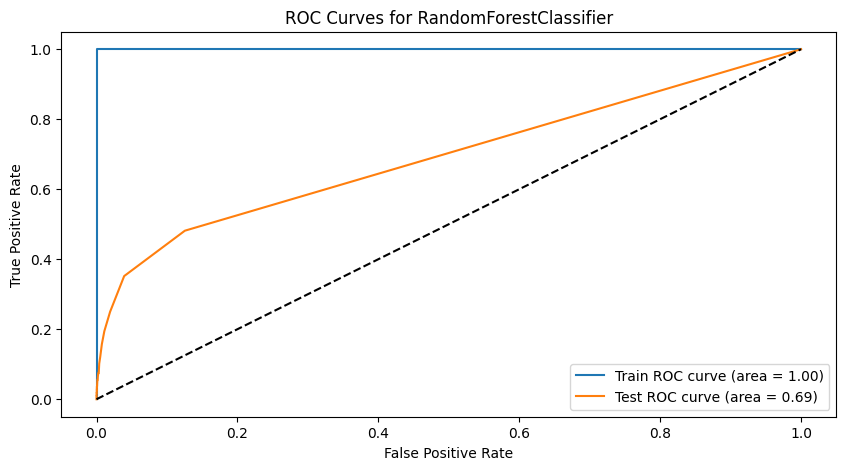

Дата та час розрахунків:  2024-04-18 15:27:01


In [ ]:
# Calculate the ROC curves for train and test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

# Plot the ROC curves
plt.figure(figsize=(10, 5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {train_auc_score:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {test_auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()

# Print the current datetime
print_current_datetime()

In [ ]:
# Convert probabilities to binary predictions using an threshold
threshold = 0.5
y_train_pred = (y_train_pred_proba >= threshold).astype(int)
y_test_pred = (y_test_pred_proba >= threshold).astype(int)

# Print the confusion matrices
print("Train Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print_current_datetime()

Train Confusion Matrix:
[[89839     0]
 [    0   161]]

Test Confusion Matrix:
[[59891     1]
 [  107     1]]
Дата та час розрахунків:  2024-04-18 05:46:35


    Train - perfect
    Test - oufull
    lets find an optimal threshold

Optimal Threshold: 0.0700
Optimal F1 Score: 0.0627


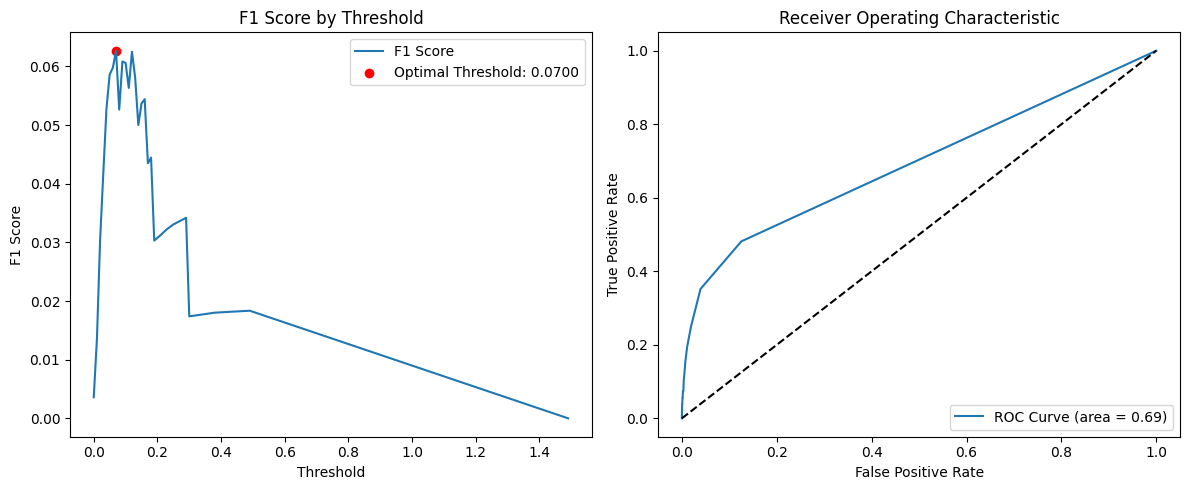

In [ ]:
# Calculate the ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate F1 score for each threshold
f1_scores = [f1_score(y_test, (y_test_pred_proba >= t).astype(int)) for t in thresholds]

# Find the optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold:.4f}')
print(f'Optimal F1 Score: {optimal_f1:.4f}')

# Plot F1 Score and AUC as function of the decision threshold
plt.figure(figsize=(12, 5))

# Subplot 1: Plot F1 Scores
plt.subplot(1, 2, 1)
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.scatter(optimal_threshold, optimal_f1, color='red', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.title('F1 Score by Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()

# Subplot 2: Plot AUC Scores
plt.subplot(1, 2, 2)
# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal for no-skill classifier 50%/50%
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Trade-off

depicted in the plots is a common challenge in classification tasks, especially in imbalanced datasets typical of scenarios like fraud detection.

F1 score plot indicates that the highest F1 is achieved at a relatively low threshold, which means the model is favoring recall over precision — the model is catching more of the positive class but also allowing more false positives.


### Calibrated technick

**Calibration** can help in refining the probability outputs, making them more representative of the true class probabilities, especially beneficial in imbalanced datasets like fraud detection.

The trained RandomForest model will be calibrated using **isotonic regression** on the validation set to adjust the probability predictions.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# X - features
# y - target

# Splitting the original dataset into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training set to create a validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

# we already encorded data earlier, let's use it

# Encode the training, validation, and test data
X_train_encoded = encoder.predict(X_train)
X_valid_encoded = encoder.predict(X_valid)
X_test_encoded = encoder.predict(X_test)

# Train the RandomForest classifier on the encoded training data
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_encoded, y_train)

# Calibrate the model using the encoded validation set
calibrated_clf = CalibratedClassifierCV(estimator=classifier, method='isotonic', cv='prefit')
calibrated_clf.fit(X_valid_encoded, y_valid)

# Predict probabilities on the encoded test set with the calibrated model
y_pred_proba_calibrated = calibrated_clf.predict_proba(X_test_encoded)[:, 1]

# Compute ROC curve for the calibrated probabilities
fpr_calibrated, tpr_calibrated, thresholds_calibrated = roc_curve(y_test, y_pred_proba_calibrated)

# Calculate the G-mean for each threshold
gmeans_calibrated = np.sqrt(tpr_calibrated * (1 - fpr_calibrated))
ix_calibrated = np.argmax(gmeans_calibrated)
optimal_threshold_calibrated = thresholds_calibrated[ix_calibrated]

# Use the optimal threshold to convert probabilities to binary predictions
y_pred_calibrated = (y_pred_proba_calibrated >= optimal_threshold_calibrated).astype(int)

# Calculate the confusion matrix and classification report
conf_matrix_calibrated = confusion_matrix(y_test, y_pred_calibrated)
class_report_calibrated = classification_report(y_test, y_pred_calibrated)

# Print results
print("Optimal Threshold (Calibrated):", optimal_threshold_calibrated)
print("Confusion Matrix (Calibrated):")
print(conf_matrix_calibrated)
print("\nClassification Report (Calibrated):")
print(class_report_calibrated)

# Calculate and print the AUC score with calibrated probabilities
auc_score_calibrated = roc_auc_score(y_test, y_pred_proba_calibrated)
print("AUC Score (Calibrated):", auc_score_calibrated)


938/938 [==============================] - 1s 1ms/step
Optimal Threshold (Calibrated): 0.0024752475247524753
Confusion Matrix (Calibrated):
[[26350  3596]
 [   26    28]]

Classification Report (Calibrated):
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     29946
           1       0.01      0.52      0.02        54

    accuracy                           0.88     30000
   macro avg       0.50      0.70      0.48     30000
weighted avg       1.00      0.88      0.93     30000

AUC Score (Calibrated): 0.7170100625570471


**Calibrations technick shows better results:**


    Optimal Threshold (Calibrated): 0.0024752475247524753
    Confusion Matrix (Calibrated):
    [[26350  3596]
    [   26    28]]

    Classification Report (Calibrated):
    precision    recall  f1-score   support

    0       1.00      0.88      0.94     29946
    1       0.01      0.52      0.02        54

    accuracy                           0.88     30000
    macro avg       0.50      0.70      0.48     30000
    weighted avg       1.00      0.88      0.93     30000

    AUC Score (Calibrated): 0.7170100625570471

### LGBMClassifier - powerfull and speedy model

In [ ]:
# Splitting the data into Features & Targets
X = df_train_pp.drop(columns='IsFraud', axis=1)
y = df_train_pp['IsFraud']

# Splitting again the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

# encorder is the same

# Encode the training and test data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

(90000, 30) (60000, 30) (90000,) (60000,)
1875/1875 [==============================] - 3s 2ms/step


In [ ]:
from lightgbm import LGBMClassifier

# Initialize LGBMClassifier with class weights
lgbm_classifier = LGBMClassifier(
    n_estimators=20,
    class_weight=class_weights_dict,
    random_state=42
)

# Fit the classifier on encoded data, specifying the eval_metric in the fit method
lgbm_classifier.fit(
    X_train_encoded, y_train,
    eval_set=[(X_train_encoded, y_train), (X_test_encoded, y_test)],
    eval_metric='auc'
)

# Now make predictions with the classifier
y_pred = lgbm_classifier.predict(X_test_encoded)  # Class predictions
y_pred_proba = lgbm_classifier.predict_proba(X_test_encoded)[:, 1]  # Probabilities

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

# Print the current datetime
print_current_datetime()

# Retrieve the performance metrics
results = lgbm_classifier.evals_result_

[LightGBM] [Info] Number of positive: 161, number of negative: 89839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
AUC Score: 0.7344237374187117
Дата та час розрахунків:  2024-04-18 15:55:27


In [ ]:
# Retrieve the performance metrics
results = lgbm_classifier.evals_result_

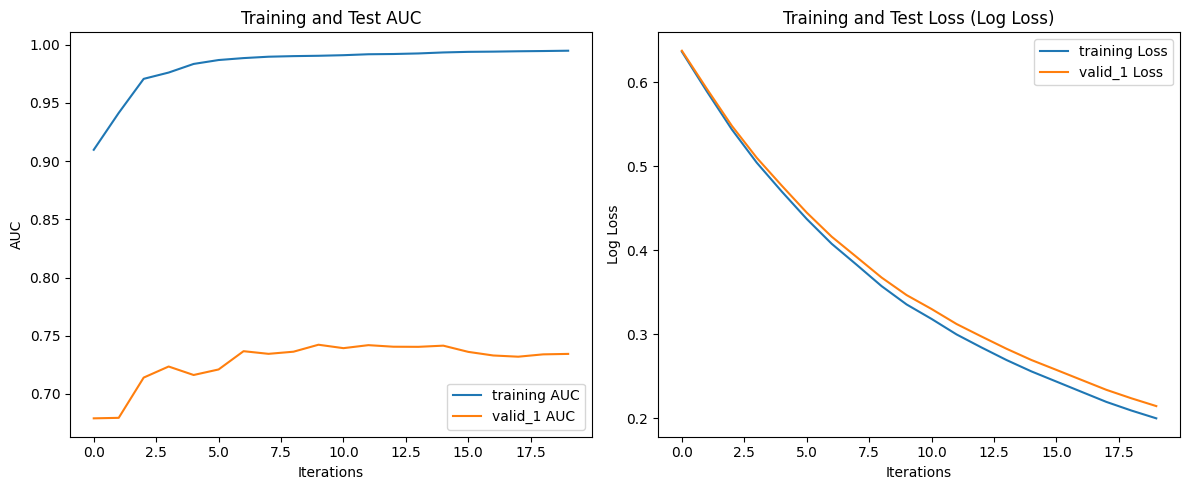

Дата та час розрахунків:  2024-04-18 15:55:34


In [ ]:
plot_lgbm(results)

**the model is learning from the training data (memorizing), it doesn't generalize as effectively to the test data, which is a classic sign of overfitting. We should consider strategies to improve the generalizability of the model.**

In [ ]:
# Calculate the ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the G-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)

# Find the optimal threshold
optimal_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (optimal_threshold, gmeans[ix]))

# Convert probabilities to class labels using the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Print the confusion matrix and classification report with the optimal threshold
print(confusion_matrix(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

print_current_datetime()

Best Threshold=0.164149, G-Mean=0.664
[[38029 21863]
 [   33    75]]
              precision    recall  f1-score   support

           0       1.00      0.63      0.78     59892
           1       0.00      0.69      0.01       108

    accuracy                           0.64     60000
   macro avg       0.50      0.66      0.39     60000
weighted avg       1.00      0.64      0.78     60000

Дата та час розрахунків:  2024-04-18 16:03:26


    Result are not bad, but the cost is high
    Best Threshold=0.164149, G-Mean=0.664
    [[38029 21863]
    [   33    75]]
    precision    recall  f1-score   support

    0       1.00      0.63      0.78     59892
    1       0.00      0.69      0.01       108

    accuracy                           0.64     60000
    macro avg       0.50      0.66      0.39     60000
    weighted avg       1.00      0.64      0.78     60000

**AUC is not bad = 0.73, but due to negative class, it is less efective on fraud detection**

Optimal Threshold: 0.8750
Optimal F1 Score: 0.0661


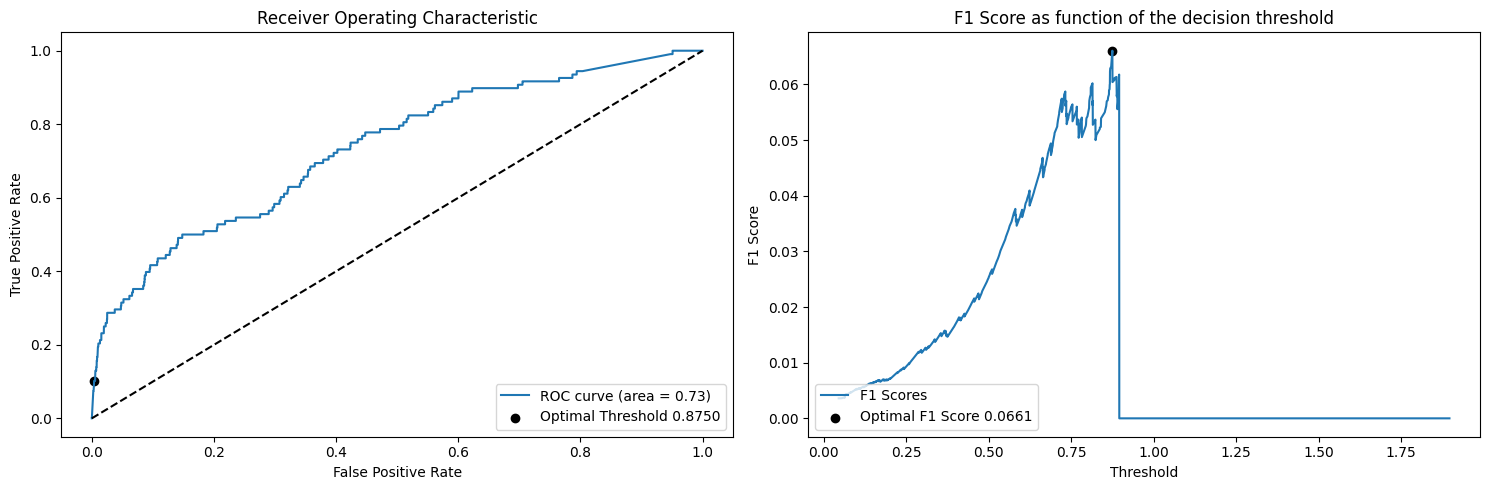

In [ ]:
from sklearn.metrics import roc_curve, f1_score, auc

# Calculate the ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate F1 score for each threshold
f1_scores = [f1_score(y_test, (y_pred_proba >= t).astype(int)) for t in thresholds]

# Find the optimal threshold and F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold:.4f}')
print(f'Optimal F1 Score: {optimal_f1:.4f}')

# Create a figure for subplots
plt.figure(figsize=(15, 5))

# Plot ROC Curve in the first subplot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label=f'Optimal Threshold {optimal_threshold:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot F1 Score Curve in the second subplot
plt.subplot(1, 2, 2)
plt.plot(thresholds, f1_scores, label='F1 Scores')
plt.scatter(optimal_threshold, optimal_f1, marker='o', color='black', label=f'Optimal F1 Score {optimal_f1:.4f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score as function of the decision threshold')
plt.legend(loc="lower left")

# Display the figure
plt.tight_layout()
plt.show()


**Precision-Recall Trade-off:**

Maximizing recall often comes at the expense of precision, especially in anomaly detection. It’s important to consider the context business application — whether false positives are tolerable or costly.

By iterating over various thresholds this way, we can more finely tune the sensitivity of your anomaly detection model to the needs the specific task, particularly in critical areas like fraud detection.

## Test and submit with LightGBM momdel

In [ ]:
test_file_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/test.csv'

df_test = pd.read_csv(test_file_path)

reduce_mem_usage(df_test)

df_test_pp = preproccess_data(df_test)

X_test = df_test_pp

print_current_datetime()

Mem. usage decreased to  4.35 Mb (73.4% reduction)
Дата та час розрахунків:  2024-04-18 16:03:58


In [ ]:
# First, encode the test data using the trained encoder part of the autoencoder
X_test_encoded = encoder.predict(X_test)
# use lightgbm classifier to make predictions
y_pred_proba_test = lgbm_classifier.predict_proba(X_test_encoded)[:, 1]

2161/2161 [==============================] - 3s 1ms/step


In [ ]:
y_pred_proba_test
print_current_datetime()

Дата та час розрахунків:  2024-04-18 16:04:53


In [ ]:
submission_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/sample_submission.csv'
sample = pd.read_csv(submission_path)
sample['IsFraud'] = y_pred_proba_test
# save to submissions
sample.to_csv('/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/anomaly_submission_encorder_lightgbmclass.csv', index=False)

# PCA - Principal Component Analysis

PCA is particularly useful when dealing with high-dimensional data, aiding in visualization, faster computation, and sometimes improved performance in machine learning models by reducing overfitting.

Let's try to reduce the number of features in our dataset by transforming them into a new set of dimensions called principal components. This could help in simplifying the dataset while retaining the most significant features that have the highest variance.

After reducing the dimensions of the data, anomalies or outliers can become more apparent. Since fraudulent activities often deviate from the 'normal' patterns, PCA can help in highlighting these anomalies by making them more distinguishable in the transformed feature space.

In [ ]:
from sklearn.decomposition import PCA
features = df_train_pp.drop('IsFraud', axis=1)
target = df_train_pp['IsFraud']
def select_pca_components(data, variance_threshold=0.9):
    pca = PCA(n_components=data.shape[1])
    pca.fit(data)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    # Find the number of components to reach the variance threshold
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    return n_components, pca
n_components, pca_model = select_pca_components(df_train_pp, variance_threshold=0.9)

pca_18 = PCA(n_components=18)  # initialize PCA to reduce the data to n_components components
pca_18.fit(features)  # fit PCA on data

# transform your data using the fitted PCA object
df_train_pp_transformed = pca_18.transform(features)

# Create a list of PCA component names
pca_columns = [f'PCA_{i+1}' for i in range(pca_18.n_components)]

# transform back in DataFrame format with column names
df_train_pca = pd.DataFrame(df_train_pp_transformed, columns=pca_columns)

In [ ]:
# Splitting the data
X = df_train_pca
y = target

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

encoding_dim = 128
# Define the autoencoder
model = Sequential([
    Dense(encoding_dim, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(encoding_dim, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(X_train.shape[1], activation='sigmoid')])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# EarlyStopping callback to halt training upon sufficient convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the autoencoder
history = model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)
print_current_datetime()

(90000, 18) (60000, 18) (90000,) (60000,)
Epoch 1/10
1407/1407 [==============================] - 5s 3ms/step - loss: 0.8811 - val_loss: 0.7676
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8086 - val_loss: 0.7495
Epoch 3/10
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7934 - val_loss: 0.7403
Epoch 4/10
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7838 - val_loss: 0.7321
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7758 - val_loss: 0.7268
Epoch 6/10
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7702 - val_loss: 0.7224
Epoch 7/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7658 - val_loss: 0.7192
Epoch 8/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.7614 - val_loss: 0.7169
Epoch 9/10
1407/1407 [==============================] - 5s 3ms/step - loss: 0.7591 - val_loss: 0.7156
Epoch 10/10
1407/1407 [=================

## Encorder part to apply on data

In [ ]:
# Extract the encoder part from the autoencoder model
encoder = Model(inputs=model.input, outputs=model.layers[-3].output)

# Encode the training and test data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

1875/1875 [==============================] - 3s 1ms/step


## Lets use RandomForestClassfifier, it showed better, robustier results on unseen data

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
classifier = RandomForestClassifier(n_estimators=200, random_state=42)

# Train the classifier on the encoded training data
classifier.fit(X_train_encoded, y_train)

# Predict probabilities on the encoded training and test set
y_train_pred_proba = classifier.predict_proba(X_train_encoded)[:, 1]  # Probabilities for the positive class on training data
y_test_pred_proba = classifier.predict_proba(X_test_encoded)[:, 1]  # Probabilities for the positive class on test data

# Calculate the AUC scores for train and test
train_auc_score = roc_auc_score(y_train, y_train_pred_proba)
test_auc_score = roc_auc_score(y_test, y_test_pred_proba)

# Print AUC scores
print("Train AUC Score:", train_auc_score)
print("Test AUC Score:", test_auc_score)

# Print the current datetime
print_current_datetime()

Train AUC Score: 1.0
Test AUC Score: 0.6548925411419567
Дата та час розрахунків:  2024-04-18 16:25:50


    Random Forest Class
    20% for test
    Train AUC Score: 1.0
    Test AUC Score: 0.6310943030788752
    Дата та час розрахунків:  2024-04-18 06:55:07
    40% for test
    Train AUC Score: 1.0
    Test AUC Score: 0.7130310639397829
    Дата та час розрахунків:  2024-04-18 14:02:19

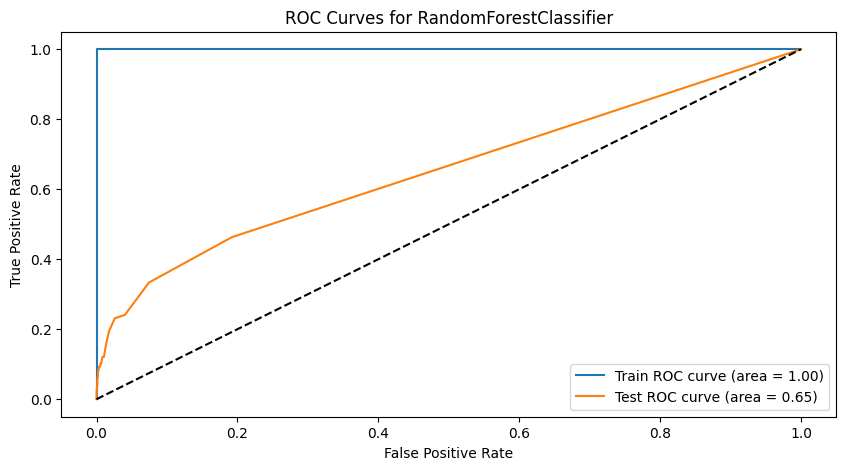

Дата та час розрахунків:  2024-04-18 16:25:50


In [ ]:
# Calculate the ROC curves for train and test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

# Plot the ROC curves
plt.figure(figsize=(10, 5))
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {train_auc_score:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {test_auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()

# Print the current datetime
print_current_datetime()

### Submit results obtained reducing dimentions, encording data and classifying data with RandomForestClassifier

In [ ]:
test_file_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/test.csv'

df_test = pd.read_csv(test_file_path)

reduce_mem_usage(df_test)

df_test_pp = preproccess_data(df_test)

X_test = df_test_pp

print_current_datetime()

Mem. usage decreased to  4.35 Mb (73.4% reduction)
Дата та час розрахунків:  2024-04-18 16:27:10


In [ ]:
# Use the fitted pca_18 to transform the test data
test_features_transformed = pca_18.transform(df_test_pp)

# Convert the transformed test features back into a DataFrame
df_test_pca = pd.DataFrame(test_features_transformed, columns=pca_columns)

# Use the encoder to encode the test data
X_test_encoded = encoder.predict(df_test_pca)

2161/2161 [==============================] - 3s 1ms/step


In [ ]:
# Now we can use the trained classifier to make predictions on the encoded test data
y_test_pred_proba = classifier.predict_proba(X_test_encoded)[:, 1]  # Probabilities for the positive class on test data

In [ ]:
submission_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/sample_submission.csv'
sample = pd.read_csv(submission_path)
sample['IsFraud'] = y_test_pred_proba
# save to submissions
sample.to_csv('/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/anomaly_submission_pca_encorder_RFclass.csv', index=False)
print_current_datetime()

Дата та час розрахунків:  2024-04-18 16:27:22


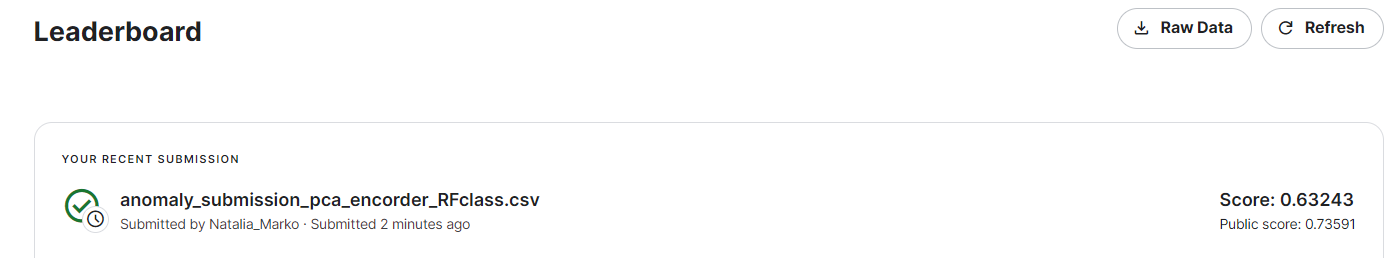

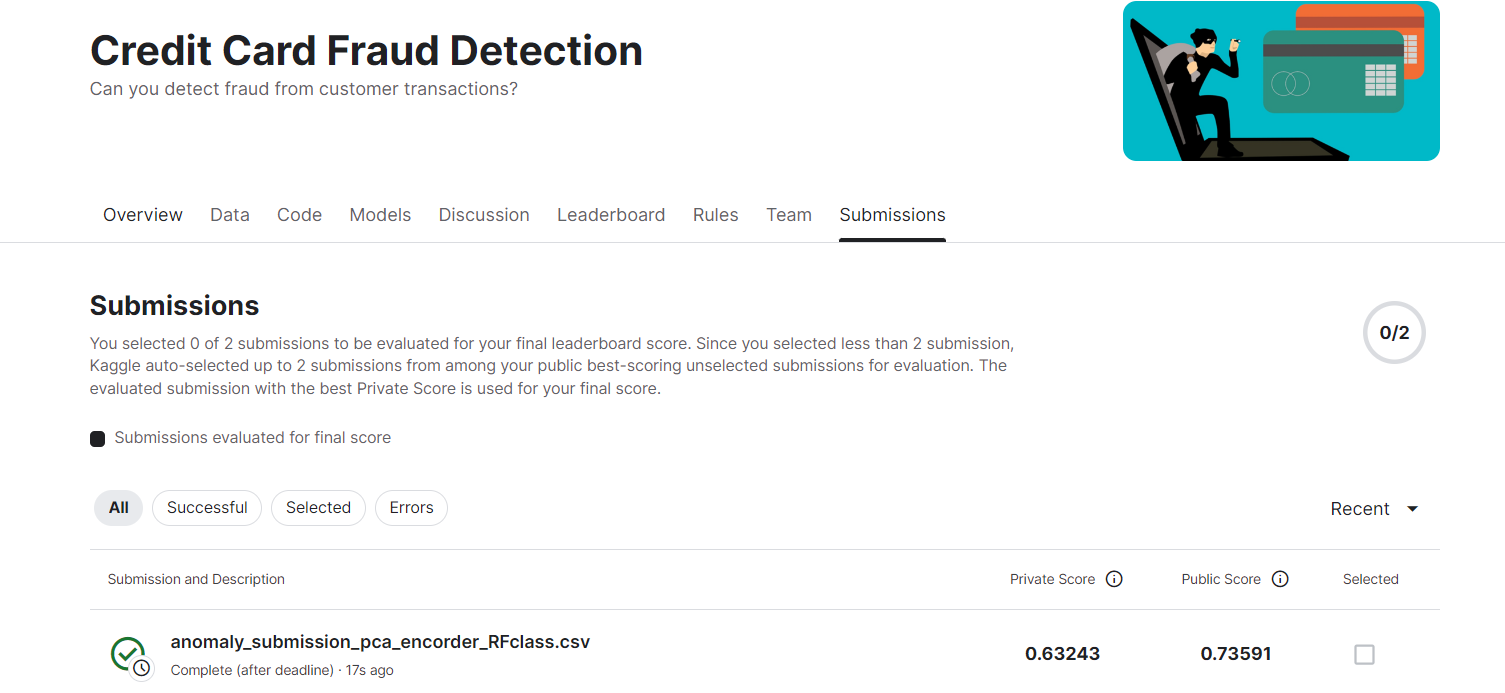

**Public score 0.7359, rank 39/71 competitors**

# Supervised learning - NN model

**Supervised learning with neural networks can be particularly effective for fraud detection tasks due to their ability to learn complex patterns from labeled data.**

## Split and define train and target data

In [ ]:
# Splitting the data into Features & Targets
X = df_train_pp.drop(columns='IsFraud', axis=1)
y = df_train_pp['IsFraud']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(90000, 30) (60000, 30) (90000,) (60000,)


## model architecture

In [ ]:
# Define the model architecture
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


## train and test NN model

Epoch 1/20
2250/2250 [==============================] - 11s 4ms/step - loss: 1.1260 - auc_2: 0.6273 - val_loss: 0.5950 - val_auc_2: 0.8055
Epoch 2/20
2250/2250 [==============================] - 9s 4ms/step - loss: 0.8737 - auc_2: 0.7184 - val_loss: 0.6953 - val_auc_2: 0.8652
Epoch 3/20
2250/2250 [==============================] - 13s 6ms/step - loss: 0.8615 - auc_2: 0.7634 - val_loss: 0.7261 - val_auc_2: 0.8666
Epoch 4/20
2250/2250 [==============================] - 10s 4ms/step - loss: 0.7840 - auc_2: 0.7805 - val_loss: 0.7465 - val_auc_2: 0.8743
Epoch 5/20
2250/2250 [==============================] - 9s 4ms/step - loss: 0.7804 - auc_2: 0.7646 - val_loss: 0.6940 - val_auc_2: 0.8599
Epoch 6/20
2250/2250 [==============================] - 7s 3ms/step - loss: 0.7557 - auc_2: 0.7906 - val_loss: 0.6773 - val_auc_2: 0.8562


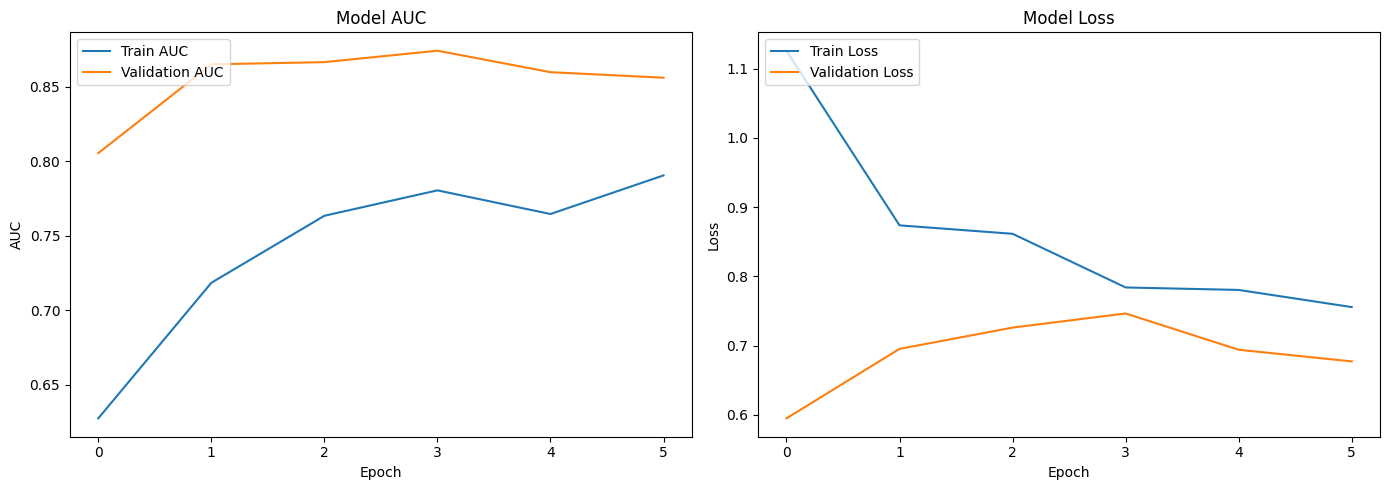

Дата та час розрахунків:  2024-04-18 16:34:29


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=[AUC()])


# EarlyStopping callback to halt training upon sufficient convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Now pass the class_weights_dict to the fit function
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

plot_training_history(history)
print_current_datetime()

### high bias and variance


- plots show AUC and loss over train and testing as being overfitted

To improve the model, we might consider strategies such as further regularization, to help the model generalize better.

Let's adjust the model's arhitecter to prevent overfitting

## change arhitecture

add some regularization instruments like:

- kernel_regularizer=l2(0.001) and Dropout(0.5)

add also one leyer consists of 64 neyrons

In [ ]:
def create_model(input_shape):
    # Define the model architecture inside a function for reusability
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
def run_training_and_plot(model, X_train, y_train, batch, lr, epoch):
    # Compute class weights for unbalanced datasets
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=[AUC()])

    # EarlyStopping callback to halt training upon sufficient convergence
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epoch,
        batch_size=batch,
        validation_split=0.2,
        class_weight=class_weights_dict,
        callbacks=[early_stopping]
    )

    # Plot training history
    plot_training_history(history)

    # Print the current date and time
    print_current_datetime()

    return model, history

## Train again

In [ ]:
# define hyperparams
lr = 0.001
epoch = 20
batch = 128
input_shape = (X_train.shape[1],)

Epoch 1/20
563/563 [==============================] - 8s 11ms/step - loss: 1.5052 - auc_11: 0.4633 - val_loss: 0.7971 - val_auc_11: 0.7474
Epoch 2/20
563/563 [==============================] - 3s 5ms/step - loss: 0.8930 - auc_11: 0.6542 - val_loss: 0.7435 - val_auc_11: 0.8726
Epoch 3/20
563/563 [==============================] - 3s 5ms/step - loss: 0.8668 - auc_11: 0.7112 - val_loss: 0.8763 - val_auc_11: 0.8901
Epoch 4/20
563/563 [==============================] - 3s 5ms/step - loss: 0.7930 - auc_11: 0.7377 - val_loss: 0.7254 - val_auc_11: 0.8591
Epoch 5/20
563/563 [==============================] - 5s 8ms/step - loss: 0.7777 - auc_11: 0.7638 - val_loss: 0.6805 - val_auc_11: 0.8602
Epoch 6/20
563/563 [==============================] - 3s 6ms/step - loss: 0.7575 - auc_11: 0.7700 - val_loss: 0.7129 - val_auc_11: 0.8400
Epoch 7/20
563/563 [==============================] - 3s 5ms/step - loss: 0.7184 - auc_11: 0.8003 - val_loss: 0.7046 - val_auc_11: 0.8409
Epoch 8/20
563/563 [=============

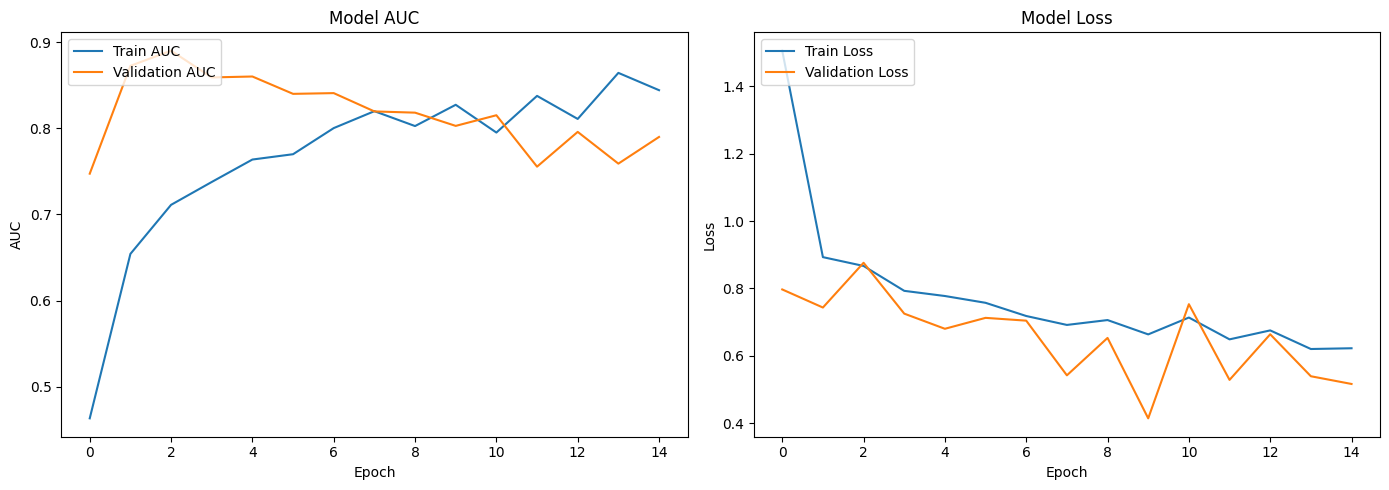

Дата та час розрахунків:  2024-04-18 16:58:50


(<keras.src.engine.sequential.Sequential at 0x7b1b3a21b610>,
 <keras.src.callbacks.History at 0x7b1b3a258ca0>)

In [ ]:
# create the model
model = create_model(input_shape)
# Now we can call the custom function
run_training_and_plot(model, X_train, y_train, batch, lr, epoch)

## Conclusion

The training and validation lines in both plots are converging, indicating good model generalization without significant overfitting.


The fluctuations in the validation metrics suggest that the model might benefit from techniques such as learning rate reduction, early stopping, or more sophisticated regularization methods to smooth out the learning process and potentially improve generalization on unseen data.


The gap between the training and validation AUC and loss metrics is not large, which indicates that the model is generalizing well, but there's still some room for improvement in model training stability and performance on the validation set.

## Cross-validation

Lets perform cross-validation step to assure more robust execution to our model

Epoch 1/10
900/900 [==============================] - 6s 5ms/step - loss: 2.1628 - auc_12: 0.4651 - val_loss: 1.0962 - val_auc_12: 0.8222
Epoch 2/10
900/900 [==============================] - 5s 5ms/step - loss: 0.9513 - auc_12: 0.6393 - val_loss: 0.8846 - val_auc_12: 0.7808
Epoch 3/10
900/900 [==============================] - 5s 5ms/step - loss: 0.8620 - auc_12: 0.7389 - val_loss: 0.7361 - val_auc_12: 0.8452
Epoch 4/10
900/900 [==============================] - 5s 5ms/step - loss: 0.8181 - auc_12: 0.7784 - val_loss: 0.7453 - val_auc_12: 0.8617
Epoch 5/10
900/900 [==============================] - 4s 4ms/step - loss: 0.7640 - auc_12: 0.8048 - val_loss: 0.7021 - val_auc_12: 0.8310
Epoch 6/10
900/900 [==============================] - 4s 5ms/step - loss: 0.7579 - auc_12: 0.8023 - val_loss: 0.5648 - val_auc_12: 0.8062
Epoch 7/10
900/900 [==============================] - 5s 6ms/step - loss: 0.7253 - auc_12: 0.7926 - val_loss: 0.7517 - val_auc_12: 0.8214
Epoch 8/10
900/900 [==============

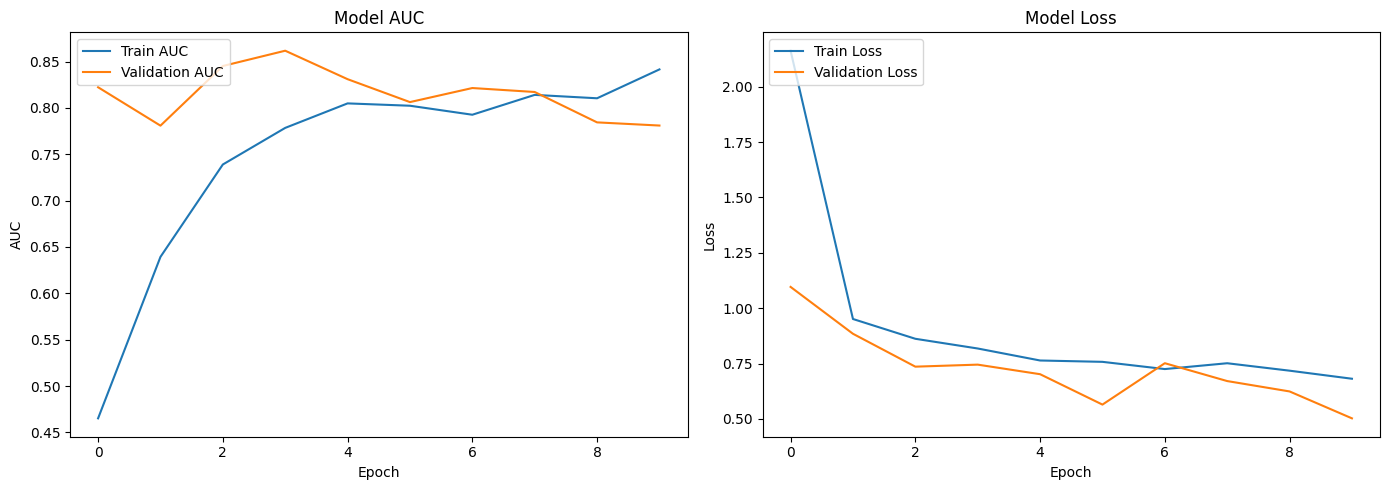

Дата та час розрахунків:  2024-04-18 17:05:25
Epoch 1/10
900/900 [==============================] - 6s 5ms/step - loss: 1.8712 - auc_13: 0.4902 - val_loss: 0.8092 - val_auc_13: 0.7669
Epoch 2/10
900/900 [==============================] - 11s 12ms/step - loss: 0.9262 - auc_13: 0.6376 - val_loss: 0.7738 - val_auc_13: 0.8370
Epoch 3/10
900/900 [==============================] - 6s 7ms/step - loss: 0.8529 - auc_13: 0.7000 - val_loss: 0.7931 - val_auc_13: 0.8174
Epoch 4/10
900/900 [==============================] - 5s 6ms/step - loss: 0.7633 - auc_13: 0.7835 - val_loss: 0.6092 - val_auc_13: 0.8024
Epoch 5/10
900/900 [==============================] - 7s 8ms/step - loss: 0.7530 - auc_13: 0.8044 - val_loss: 0.7347 - val_auc_13: 0.8457
Epoch 6/10
900/900 [==============================] - 7s 7ms/step - loss: 0.7787 - auc_13: 0.7649 - val_loss: 0.6943 - val_auc_13: 0.7986
Epoch 7/10
900/900 [==============================] - 5s 6ms/step - loss: 0.7196 - auc_13: 0.8121 - val_loss: 0.5898 - val_a

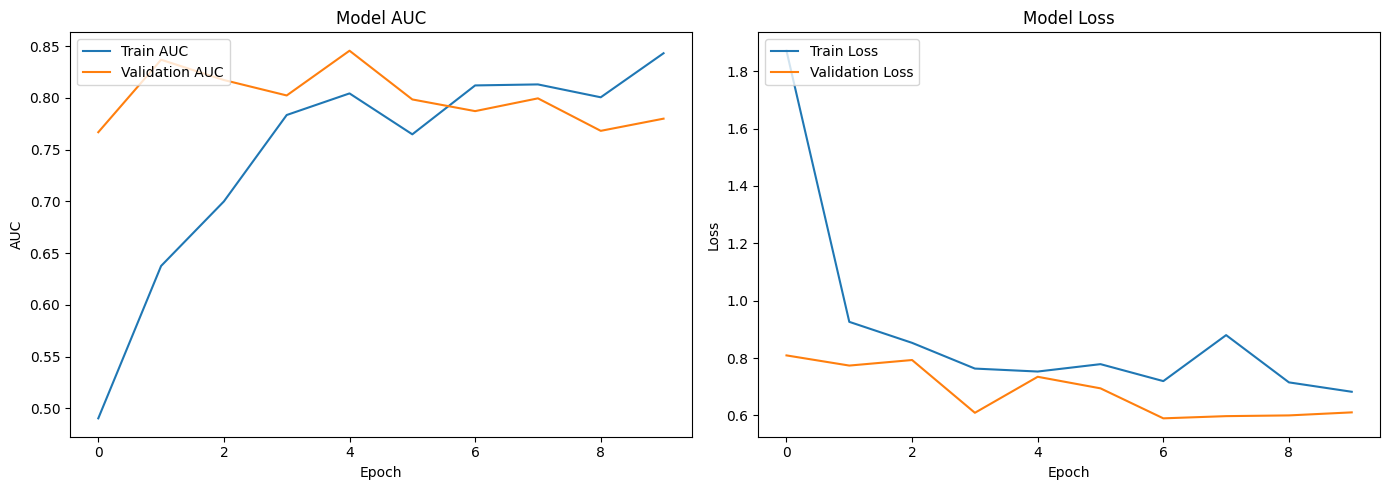

Дата та час розрахунків:  2024-04-18 17:06:28
Epoch 1/10
900/900 [==============================] - 8s 6ms/step - loss: 1.7466 - auc_14: 0.5442 - val_loss: 0.7285 - val_auc_14: 0.8551
Epoch 2/10
900/900 [==============================] - 4s 5ms/step - loss: 0.9228 - auc_14: 0.6730 - val_loss: 0.7853 - val_auc_14: 0.8954
Epoch 3/10
900/900 [==============================] - 4s 5ms/step - loss: 0.8650 - auc_14: 0.7336 - val_loss: 0.8274 - val_auc_14: 0.8935
Epoch 4/10
900/900 [==============================] - 5s 6ms/step - loss: 0.7990 - auc_14: 0.7714 - val_loss: 0.7106 - val_auc_14: 0.8804
Epoch 5/10
900/900 [==============================] - 5s 5ms/step - loss: 0.8353 - auc_14: 0.8006 - val_loss: 0.6807 - val_auc_14: 0.8726
Epoch 6/10
900/900 [==============================] - 5s 5ms/step - loss: 0.7706 - auc_14: 0.8128 - val_loss: 0.6874 - val_auc_14: 0.8515
Epoch 7/10
900/900 [==============================] - 6s 7ms/step - loss: 0.7258 - auc_14: 0.8325 - val_loss: 0.5683 - val_auc

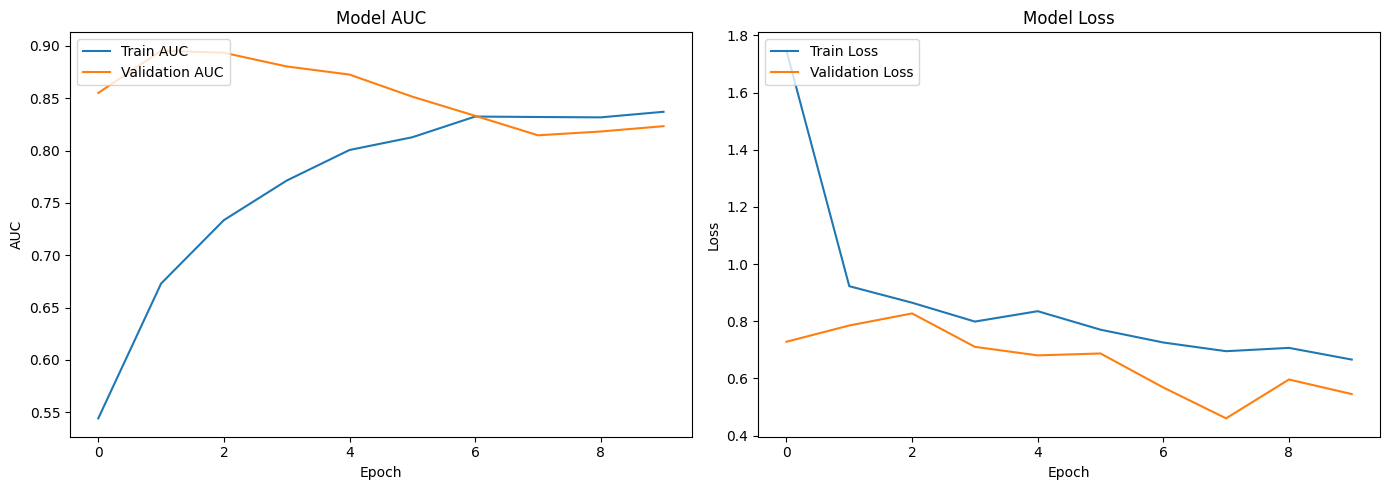

Дата та час розрахунків:  2024-04-18 17:07:22
Epoch 1/10
900/900 [==============================] - 10s 9ms/step - loss: 1.9032 - auc_15: 0.5109 - val_loss: 0.8071 - val_auc_15: 0.7707
Epoch 2/10
900/900 [==============================] - 8s 9ms/step - loss: 1.0341 - auc_15: 0.6595 - val_loss: 0.7730 - val_auc_15: 0.8540
Epoch 3/10
900/900 [==============================] - 7s 8ms/step - loss: 0.8832 - auc_15: 0.7130 - val_loss: 0.9335 - val_auc_15: 0.8577
Epoch 4/10
900/900 [==============================] - 7s 8ms/step - loss: 0.8425 - auc_15: 0.7531 - val_loss: 0.8101 - val_auc_15: 0.8718
Epoch 5/10
900/900 [==============================] - 7s 8ms/step - loss: 0.8393 - auc_15: 0.7624 - val_loss: 0.5092 - val_auc_15: 0.8030
Epoch 6/10
900/900 [==============================] - 5s 5ms/step - loss: 0.7545 - auc_15: 0.7837 - val_loss: 0.7878 - val_auc_15: 0.8331
Epoch 7/10
900/900 [==============================] - 4s 4ms/step - loss: 0.7341 - auc_15: 0.8091 - val_loss: 0.4725 - val_au

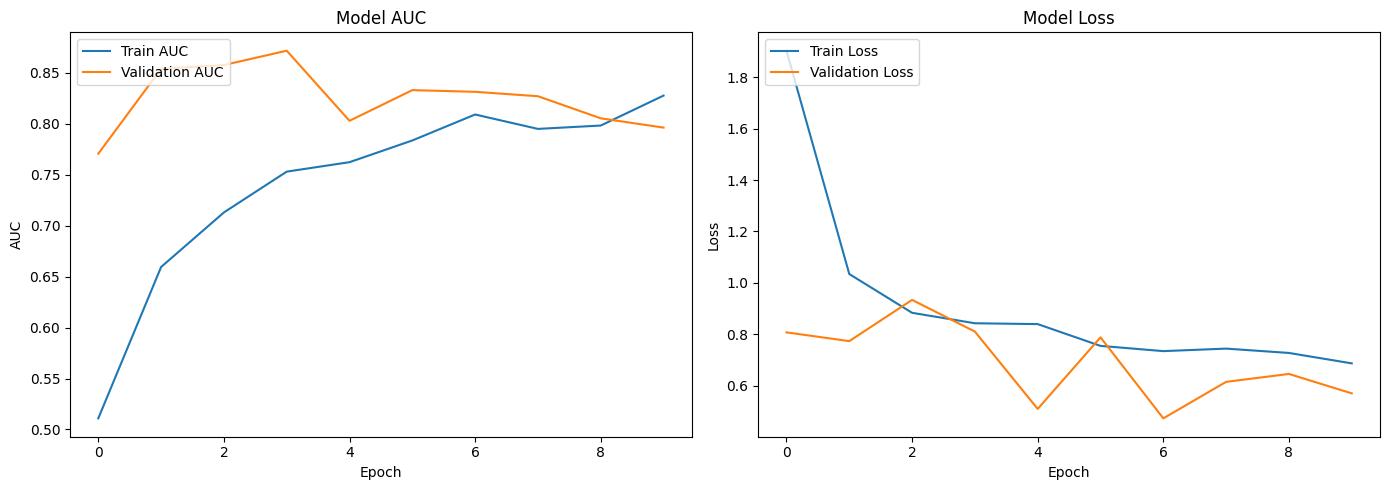

Дата та час розрахунків:  2024-04-18 17:08:29
Epoch 1/10
900/900 [==============================] - 7s 6ms/step - loss: 2.1054 - auc_16: 0.5205 - val_loss: 0.7363 - val_auc_16: 0.5800
Epoch 2/10
900/900 [==============================] - 6s 7ms/step - loss: 1.0945 - auc_16: 0.6349 - val_loss: 0.8213 - val_auc_16: 0.8673
Epoch 3/10
900/900 [==============================] - 7s 8ms/step - loss: 0.9390 - auc_16: 0.6895 - val_loss: 0.8323 - val_auc_16: 0.8835
Epoch 4/10
900/900 [==============================] - 9s 10ms/step - loss: 0.9091 - auc_16: 0.7440 - val_loss: 0.9209 - val_auc_16: 0.8913
Epoch 5/10
900/900 [==============================] - 19s 22ms/step - loss: 0.8046 - auc_16: 0.7626 - val_loss: 0.8336 - val_auc_16: 0.8659
Epoch 6/10
900/900 [==============================] - 13s 15ms/step - loss: 0.7514 - auc_16: 0.7981 - val_loss: 0.7545 - val_auc_16: 0.8633


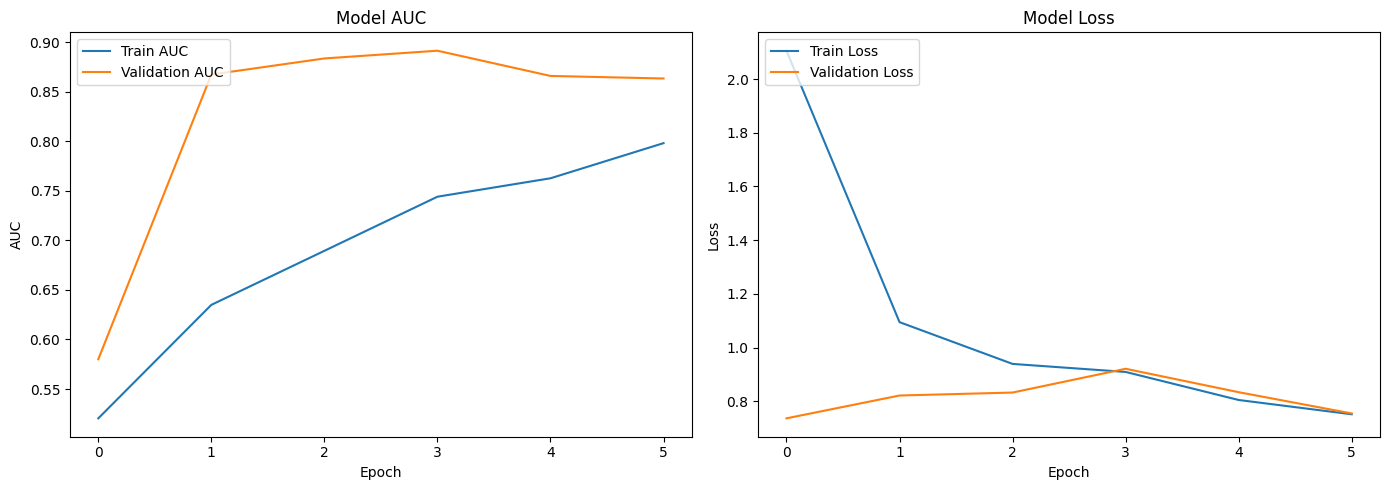

Дата та час розрахунків:  2024-04-18 17:09:37
Mean AUC: 0.72, Standard Deviation: 0.04


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare cross-validation results
cv_scores = []

X_train_np = X_train.values  # Only if X_train is a DataFrame
y_train_np = y_train.values  # Only if y_train is a Series

# Now, we can call create_model within your cross-validation loop
for train_index, val_index in kf.split(X_train_np, y_train_np):
    fold_X_train, fold_X_val = X_train_np[train_index], X_train_np[val_index]
    fold_y_train, fold_y_val = y_train_np[train_index], y_train_np[val_index]

    # Create a new instance of the model for this fold
    model = create_model((fold_X_train.shape[1],))

    # Use your custom training function
    trained_model, history = run_training_and_plot(
        model,
        fold_X_train,
        fold_y_train,
        batch=64,
        lr=0.001,
        epoch=10
    )

    # Evaluate the model
    scores = trained_model.evaluate(fold_X_val, fold_y_val, verbose=0)
    cv_scores.append(scores)

# Calculate average and standard deviation of cross-validation scores
cv_scores = np.array(cv_scores)
mean_auc = cv_scores[:, 1].mean()  # Make sure the index 1 corresponds to the AUC score
std_auc = cv_scores[:, 1].std()

print(f"Mean AUC: {mean_auc:.2f}, Standard Deviation: {std_auc:.2f}")

The model appears to be learning effectively, as evidenced by increasing AUC and decreasing loss in both the training and validation sets.

*   cv_scores: 0.6949, 0.7521, 0.7324, 0.7754, 0.6650
*   Mean AUC: 0.72, Standard Deviation: 0.04

There are signs that it might be beginning to overfit, suggested by the plateauing validation AUC and the small gap between the training and validation AUC.

To improve the model, you might consider strategies such as early stopping, further regularization, or more training data to help the model generalize better. Additionally, ensuring that the validation set is representative of the problem space is important for accurate evaluation of model performance.

## Final NN Model Training

Once we're satisfied with the model's performance and stability, let's train the model on the entire training set.

In [ ]:
#  define data
y_train = df_train_pp['IsFraud']
X_train = df_train_pp.drop(columns='IsFraud', axis=1)

# create the model
input_shape = (X_train.shape[1],)
model = create_model(input_shape)

# define hyperparams
lr = 0.001
epoch = 20
batch = 128

# define class weights
class_weights_dict = {0: 0.5, 1: 279.5}

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=[AUC()])

# EarlyStopping callback to halt training upon sufficient convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train,
          epochs=epoch,
    batch_size=batch,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    validation_split=0.2

)

# Print the current date and time
print_current_datetime()


Epoch 1/20
938/938 [==============================] - 11s 10ms/step - loss: 1.3546 - auc_17: 0.5710 - val_loss: 0.9263 - val_auc_17: 0.7499
Epoch 2/20
938/938 [==============================] - 5s 6ms/step - loss: 0.8522 - auc_17: 0.7193 - val_loss: 0.8812 - val_auc_17: 0.7857
Epoch 3/20
938/938 [==============================] - 6s 6ms/step - loss: 0.8239 - auc_17: 0.7791 - val_loss: 0.6253 - val_auc_17: 0.7688
Epoch 4/20
938/938 [==============================] - 10s 10ms/step - loss: 0.7939 - auc_17: 0.7664 - val_loss: 0.6470 - val_auc_17: 0.7849
Epoch 5/20
938/938 [==============================] - 8s 8ms/step - loss: 0.7436 - auc_17: 0.7898 - val_loss: 0.6360 - val_auc_17: 0.7896
Epoch 6/20
938/938 [==============================] - 6s 6ms/step - loss: 0.7073 - auc_17: 0.8032 - val_loss: 0.5971 - val_auc_17: 0.7971
Epoch 7/20
938/938 [==============================] - 5s 5ms/step - loss: 0.7174 - auc_17: 0.7890 - val_loss: 0.5212 - val_auc_17: 0.7704
Epoch 8/20
938/938 [==========

**We achieved greate results, lets proceed with unseen data**

# TEST STEP

In [ ]:
test_file_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/test.csv'
df_test = pd.read_csv(test_file_path)

reduce_mem_usage(df_test)

df_test_pp = preproccess_data(df_test)

# predict probabilities for the test set
X_test = df_test_pp

Mem. usage decreased to  4.35 Mb (73.4% reduction)


In [ ]:
y_pred_probabilities = model.predict(X_test)

2161/2161 [==============================] - 6s 3ms/step


# Submission

In [ ]:
submission_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/sample_submission.csv'
sample = pd.read_csv(submission_path)
sample['IsFraud'] = y_test_pred_proba
# save to submissions
sample.to_csv('/content/drive/MyDrive/Credit_Card_Fraud_Detection_2024/anomaly_submission_NN.csv', index=False)
print_current_datetime()

Дата та час розрахунків:  2024-04-18 17:35:13


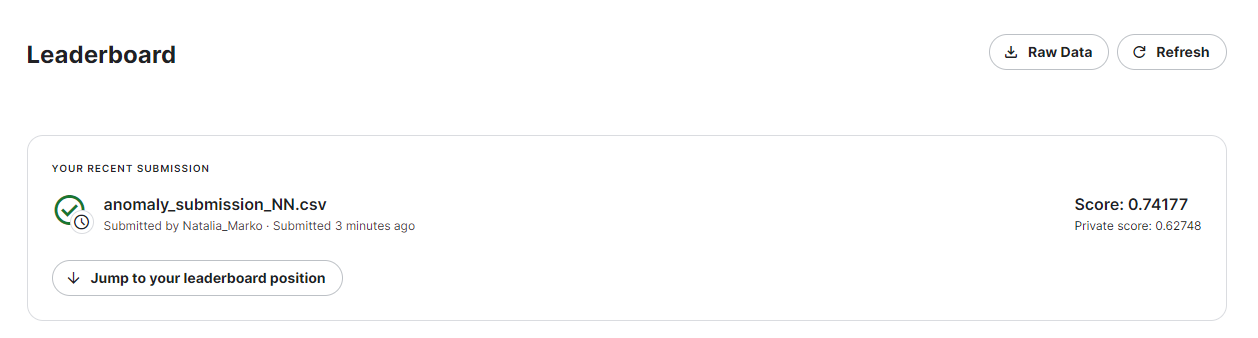

my rank 40/71

case kaggle competition:

https://www.kaggle.com/competitions/credit-card-fraud-prediction


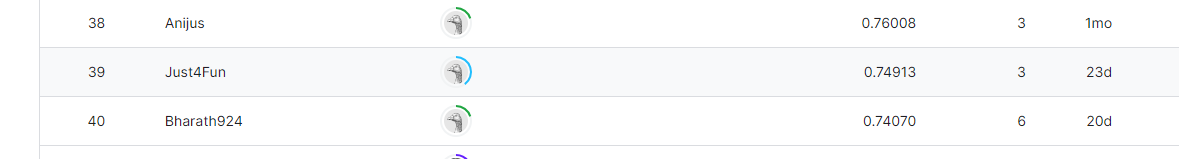

**P.S.:**

**Incorporating PCA technique into the fraud detection framework, the Encoded model coupled with a Random Forest classifier, was instrumental in enhancing model performance.**

**By applying PCA for dimensionality reduction, the models were able to focus on the most informative features, leading to an improved AUC score beyond 0.6. This strategy was particularly advantageous in the context of highly imbalanced data, assisting the model to better distinguish between the rare fraudulent cases and the predominant legitimate transactions.**

**On the other hand - Neural Network model, excels at capturing complex patterns through its layers, leads to the same results as prevous ones, but in the natural mode.**